## Brain Tumor Detection from MRI Images using Convolutional Neural Networks (CNNs)

**Goal**: The goal of this project is to develop a deep learning model based on Convolutional Neural Networks (CNNs) that can automatically classify brain MRI scans into two categories: tumor and no tumor. By leveraging image processing and deep learning techniques, the model aims to assist in early and accurate detection of brain tumors, which can support radiologists and improve medical decision-making.

In [1]:
#needed libraries
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from PIL import Image
import hashlib
from sklearn.utils import class_weight
from tensorflow.keras.applications import MobileNetV2



In [2]:
#image settings
img_size = (224, 224)   
batch_size = 32

# Load datasets
dataset = tf.keras.utils.image_dataset_from_directory(
    "brain_tumor_dataset",
    image_size=img_size,
    batch_size=batch_size)

# resize images and normalize pixel values
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = dataset.map(lambda x, y: (normalization_layer(x), y))

print("classes:",dataset.class_names)

Found 253 files belonging to 2 classes.
classes: ['no', 'yes']


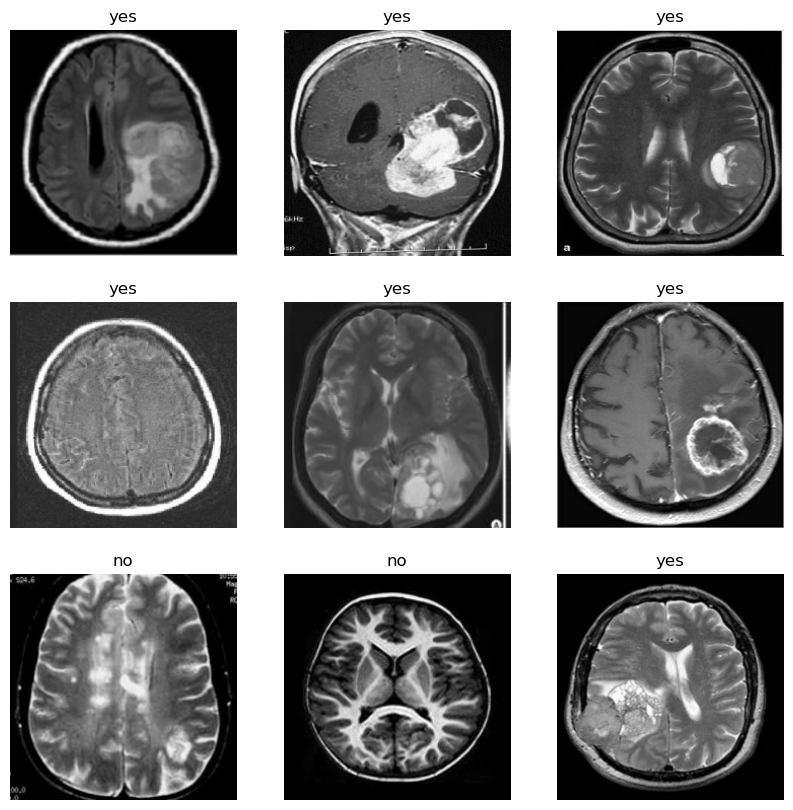

In [3]:
for images, labels in dataset.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9): #show 9 images
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(dataset.class_names[labels[i]])
        plt.axis("off")
    plt.show()

**Data Preprocessing**

In [4]:
# check for corrupted images
num_skipped = 0
for folder_name in ("no", "yes"):
    folder_path = os.path.join("brain_tumor_dataset", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)


Deleted 13 images


In [5]:
# check for duplicated images
image_hashes = set()
duplicate = 0
for folder_name in ("no", "yes"):
    folder_path = os.path.join("brain_tumor_dataset", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        img = Image.open(fpath)
        img = img.resize(img_size)
        img_array = np.array(img)

       # Hash the raw bytes
        img_hash = hashlib.md5(img_array.tobytes()).hexdigest()
        
        if img_hash in image_hashes:
            duplicate += 1
            os.remove(fpath)
            print("Deleted duplicate:", fpath)
        else:
            image_hashes.add(img_hash)

print("Deleted %d duplicate images" % duplicate)

Deleted duplicate: brain_tumor_dataset\no\27 no.jpg
Deleted duplicate: brain_tumor_dataset\no\41 no.jpg
Deleted duplicate: brain_tumor_dataset\no\42 no.jpg
Deleted duplicate: brain_tumor_dataset\no\8 no.jpg
Deleted duplicate: brain_tumor_dataset\no\9 no.jpg
Deleted duplicate: brain_tumor_dataset\no\N5.jpg
Deleted duplicate: brain_tumor_dataset\no\no 1.jpg
Deleted duplicate: brain_tumor_dataset\no\no 94.jpg
Deleted duplicate: brain_tumor_dataset\no\No11.jpg
Deleted duplicate: brain_tumor_dataset\yes\Y162.jpg
Deleted duplicate: brain_tumor_dataset\yes\Y169.jpg
Deleted duplicate: brain_tumor_dataset\yes\Y17.jpg
Deleted duplicate: brain_tumor_dataset\yes\Y181.jpg
Deleted duplicate: brain_tumor_dataset\yes\Y33.jpg
Deleted duplicate: brain_tumor_dataset\yes\Y34.jpg
Deleted duplicate: brain_tumor_dataset\yes\Y37.jpg
Deleted duplicate: brain_tumor_dataset\yes\Y38.jpg
Deleted duplicate: brain_tumor_dataset\yes\Y54.jpg
Deleted duplicate: brain_tumor_dataset\yes\Y62.jpg
Deleted duplicate: brain_t

In [6]:
# Reload dataset after cleaning

dataset = tf.keras.utils.image_dataset_from_directory(
    "brain_tumor_dataset",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)
class_names = dataset.class_names
print("Classes:", class_names)

# Normalize
normalization_layer = tf.keras.layers.Rescaling(1./255)
dataset = dataset.map(lambda x, y: (normalization_layer(x), y))



Found 217 files belonging to 2 classes.
Classes: ['no', 'yes']


In [7]:
#split train and test 
# total number of batches
dataset_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.7 * dataset_size)  
val_size = int(0.15 * dataset_size) 

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)


In [8]:
#data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"), #flip images
    tf.keras.layers.RandomRotation(0.4), #rotate the image
    tf.keras.layers.RandomZoom(0.3), #zoom the image in and out
    tf.keras.layers.RandomTranslation(0.3,0.3), #flips the image slightly
    tf.keras.layers.RandomContrast(0.2), #adjust the image contrast

])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


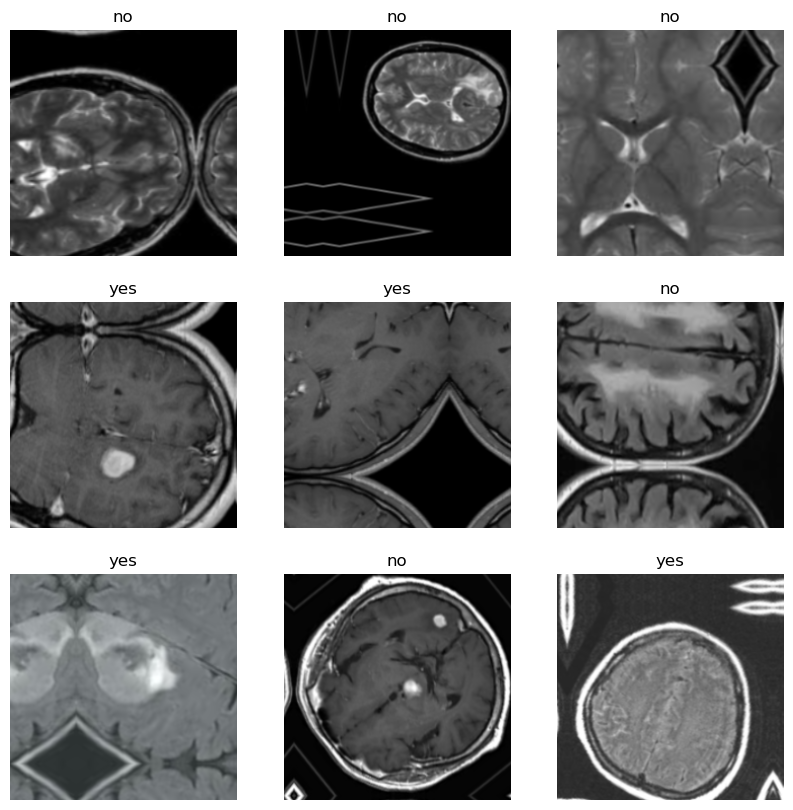

In [9]:


for images, labels in train_ds.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9): #show 9 images
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

In [10]:
#normalization
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
class_counts = {}
for _, label in train_ds.unbatch():
    label = int(label.numpy())
    class_counts[label] = class_counts.get(label, 0) + 1

print("Class distribution:", class_counts)
total_images = sum(class_counts.values())

Class distribution: {1: 79, 0: 49}


In [13]:
#h handle class imbalance

labels = [label.numpy() for _, label in train_ds.unbatch()]
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: 1.3061224489795917, 1: 0.810126582278481}


**Modelling**

In [14]:
model = models.Sequential([layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
                           layers.MaxPooling2D(2,2),
                           layers.Conv2D(32, (3,3), activation='relu'),
                           layers.MaxPooling2D(2,2),
                           layers.Conv2D(64, (3,3), activation='relu'),
                           layers.MaxPooling2D(2,2),
                           layers.Flatten(),
                           layers.Dense(64, activation='relu'),
                           layers.Dropout(0.5),
                           layers.Dense(1, activation='sigmoid')])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)      

In [15]:
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs=20)

Epoch 1/20
4/4 [==============================] - 9s 2s/step - loss: 0.7293 - accuracy: 0.6328 - val_loss: 0.6597 - val_accuracy: 0.6250
Epoch 2/20
4/4 [==============================] - 7s 2s/step - loss: 0.6931 - accuracy: 0.6172 - val_loss: 0.6817 - val_accuracy: 0.6250
Epoch 3/20
4/4 [==============================] - 7s 2s/step - loss: 0.6786 - accuracy: 0.6172 - val_loss: 0.6691 - val_accuracy: 0.6250
Epoch 4/20
4/4 [==============================] - 6s 2s/step - loss: 0.6735 - accuracy: 0.6172 - val_loss: 0.6612 - val_accuracy: 0.6250
Epoch 5/20
4/4 [==============================] - 6s 2s/step - loss: 0.6750 - accuracy: 0.6172 - val_loss: 0.6614 - val_accuracy: 0.6250
Epoch 6/20
4/4 [==============================] - 6s 2s/step - loss: 0.6701 - accuracy: 0.6172 - val_loss: 0.6618 - val_accuracy: 0.6250
Epoch 7/20
4/4 [==============================] - 6s 2s/step - loss: 0.6773 - accuracy: 0.6172 - val_loss: 0.6627 - val_accuracy: 0.6250
Epoch 8/20
4/4 [=========================

In [16]:
#transfer learning

base_model = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze base

model1 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model1.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,422,081
Trainable params: 164,097
Non-

In [17]:
history = model1.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20


4/4 [==============================] - 11s 2s/step - loss: 1.1245 - accuracy: 0.5312 - val_loss: 0.7189 - val_accuracy: 0.6250
Epoch 2/20
4/4 [==============================] - 6s 2s/step - loss: 0.7874 - accuracy: 0.4844 - val_loss: 0.8603 - val_accuracy: 0.3750
Epoch 3/20
4/4 [==============================] - 6s 2s/step - loss: 0.8035 - accuracy: 0.4375 - val_loss: 0.6618 - val_accuracy: 0.6250
Epoch 4/20
4/4 [==============================] - 6s 1s/step - loss: 0.7930 - accuracy: 0.5781 - val_loss: 0.7365 - val_accuracy: 0.6250
Epoch 5/20
4/4 [==============================] - 5s 1s/step - loss: 0.7484 - accuracy: 0.6172 - val_loss: 0.6667 - val_accuracy: 0.6250
Epoch 6/20
4/4 [==============================] - 6s 2s/step - loss: 0.6789 - accuracy: 0.5938 - val_loss: 0.6754 - val_accuracy: 0.6250
Epoch 7/20
4/4 [==============================] - 6s 2s/step - loss: 0.6760 - accuracy: 0.6016 - val_loss: 0.6802 - val_accuracy: 0.6250
Epoch 8/20
4/4 [==============================] - 6